# Code to create a simple flat sky simulation of an underlying power spectrum

In [1]:
import numpy as np, sys, os, warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
cmap = cm.RdYlBu_r

In [2]:
rcParams['figure.dpi'] = 150
rcParams["figure.facecolor"] = 'white'

In [3]:
def get_lxly(flatskymapparams):

    """
    return lx, ly modes (kx, ky Fourier modes) for a flatsky map grid.
    """
    
    ny, nx, dx = flatskymapparams
    dx = np.radians(dx/60.)

    lx, ly = np.meshgrid( np.fft.fftfreq( nx, dx ), np.fft.fftfreq( ny, dx ) )
    lx *= 2* np.pi
    ly *= 2* np.pi

    return lx, ly

def cl_to_cl2d(el, cl, flatskymapparams):
    
    """
    Interpolating a 1d power spectrum (cl) defined on multipoles (el) to 2D assuming azimuthal symmetry (i.e:) isotropy.
    """
    
    lx, ly = get_lxly(flatskymapparams)
    ell = np.sqrt(lx**2. + ly**2.)
    cl2d = np.interp(ell.flatten(), el, cl, left = 0., right = 0.).reshape(ell.shape)
    return cl2d

def make_gaussian_realisation(mapparams, el, cl, bl = None):

    """
    create Gaussian realisation of an underlying power spectrum

    input:
    mapparams = [ny, nx, dx] where ny, nx = flatskymap.shape; and dx is the pixel resolution in arcminutes.
    for example: [100, 100, 0.5] is a 50' x 50' flatskymap that has dimensions 100 x 100 with dx = 0.5 arcminutes.

    el: multiple bins over which the input power spectrum cl is defined.
    cl: input power spectrum.
    bl: smoothing function (the telescope beam).

    output:
    simulated Gaussian realisation of the input power spectrum
    """

    ny, nx, dx = mapparams
    arcmins2radians = np.radians(1/60.)

    dx *= arcmins2radians

    ################################################
    #map stuff
    norm = np.sqrt(1./ (dx**2.))
    ################################################

    cltwod = cl_to_cl2d(el, cl, mapparams)

    cltwod = cltwod**0.5 * norm
    cltwod[np.isnan(cltwod)] = 0.

    gauss_reals = np.random.standard_normal([nx,ny])
    #print(gauss_reals[0,0], cl[20:23]); 
    SIM = np.fft.ifft2( np.copy( cltwod ) * np.fft.fft2( gauss_reals ) ).real

    #add beam
    if bl is not None:
        if np.ndim(bl) != 2:
            bl = cl_to_cl2d(el, bl, mapparams)
        SIM = np.fft.ifft2( np.fft.fft2(SIM) * bl).real

    #remove mean
    SIM = SIM - np.mean(SIM)

    return SIM

def map2cl(flatskymapparams, flatskymap1, flatskymap2 = None, binsize = None, mask = None, filter_2d = None):

    """
    map2cl module - get the power spectra of map/maps

    input:
    flatskymyapparams = [ny, nx, dx] where ny, nx = flatskymap.shape; and dx is the pixel resolution in arcminutes.
    for example: [100, 100, 0.5] is a 50' x 50' flatskymap that has dimensions 100 x 100 with dx = 0.5 arcminutes.

    flatskymap1: map1 with dimensions (ny, nx)
    flatskymap2: provide map2 with dimensions (ny, nx) cross-spectra

    binsize: el bins. computed automatically if None

    cross_power: if set, then compute the cross power between flatskymap1 and flatskymap2

    output:
    auto/cross power spectra: [el, cl, cl_err]
    """

    ny, nx, dx = flatskymapparams
    dx_rad = np.radians(dx/60.)

    lx, ly = get_lxly(flatskymapparams)

    if binsize == None:
        binsize = lx.ravel()[1] -lx.ravel()[0]

    if flatskymap2 is None:
        flatskymap_psd = abs( np.fft.fft2(flatskymap1) * dx_rad)** 2 / (nx * ny)
    else: #cross spectra now
        assert flatskymap1.shape == flatskymap2.shape
        flatskymap_psd = np.fft.fft2(flatskymap1) * dx_rad * np.conj( np.fft.fft2(flatskymap2) ) * dx_rad / (nx * ny)

    rad_prf = radial_profile(flatskymap_psd, (lx,ly), bin_size = binsize, minbin = 100, maxbin = 10000, to_arcmins = 0)
    el, cl = rad_prf[:,0], rad_prf[:,1]

    if mask is not None:
        fsky = np.mean(mask)
        cl /= fsky

    if filter_2d is not None:
        rad_prf_filter_2d = radial_profile(filter_2d, (lx,ly), bin_size = binsize, minbin = 100, maxbin = 10000, to_arcmins = 0)
        el, fl = rad_prf_filter_2d[:,0], rad_prf_filter_2d[:,1]
        cl /= fl

    return el, cl

################################################################################################################

def radial_profile(z, xy = None, bin_size = 1., minbin = 0., maxbin = 10., to_arcmins = 1):

    """
    get the radial profile of an image (both real and fourier space).
    """

    z = np.asarray(z)
    if xy is None:
        x, y = np.indices(image.shape)
    else:
        x, y = xy

    #radius = np.hypot(X,Y) * 60.
    radius = (x**2. + y**2.) ** 0.5
    if to_arcmins: radius *= 60.

    binarr=np.arange(minbin,maxbin,bin_size)
    radprf=np.zeros((len(binarr),3))

    hit_count=[]

    for b,bin in enumerate(binarr):
        ind=np.where((radius>=bin) & (radius<bin+bin_size))
        radprf[b,0]=(bin+bin_size/2.)
        hits = len(np.where(abs(z[ind])>0.)[0])

        if hits>0:
            radprf[b,1]=np.sum(z[ind])/hits
            radprf[b,2]=np.std(z[ind])
        hit_count.append(hits)

    hit_count=np.asarray(hit_count)
    std_mean=np.sum(radprf[:,2]*hit_count)/np.sum(hit_count)
    errval=std_mean/(hit_count)**0.5
    radprf[:,2]=errval

    return radprf

In [4]:
#get params for sim generation
lmax = 5000
els = np.arange(lmax)
boxsize_arcmins, dx = 600., 1.0 #arcminutes

#get ra, dec or map-pixel grid
nx = int(boxsize_arcmins/dx)
mapparams = [nx, nx, dx, dx]
x1,x2 = -nx/2. * dx, nx/2. * dx

ra_for_grid = np.linspace(x1,x2, nx)/60.
dec_for_grid = np.linspace(x1,x2, nx)/60.
ra_grid, dec_grid = np.meshgrid(ra_for_grid,dec_for_grid)

In [5]:
#flat-spectrum (White noise)
fluc_level = 10. ##1e-3 ##1. #10. #uK
fluc_level_radians = fluc_level * np.radians(1/60.)
nl = np.tile( fluc_level_radians**2., lmax ) #noise power spectrum

In [6]:
#get CMB power spectrum now using CAMB
import camb #https://camb.readthedocs.io/en/latest/CAMBdemo.html
from camb import model, initialpower
diff_cosmo_dic = {'lcdm': [r'Fiducial', 'darkgreen'], 
                  'low_baryons': [r'Low Baryon Density', 'navy'], 
                  'more_baryons': [r'High Baryon Density', 'darkred'],
                  #'high_scalar': [r'More initial power', 'goldenrod'],
                  #'curved': [r'Curved', 'purple']
                 }
cl_cmb_dic = {}
for keyname in diff_cosmo_dic:
    print('Generating CMB spectra for %s cosmology' %(keyname))
    if keyname == 'lcdm':
        ombh2, omch2 = 0.022, 0.122
        As,omk = 2e-9, 0.
    elif keyname == 'low_baryons':
        ombh2, omch2 = 0.012, 0.132
        As,omk = 2e-9, 0.
    elif keyname == 'more_baryons':
        ombh2, omch2 = 0.032, 0.112
        As,omk = 2e-9, 0.
    elif keyname == 'high_scalar':
        ombh2, omch2 = 0.032, 0.112
        As,omk = 4e-9, 0.
    elif keyname == 'curved':
        ombh2, omch2 = 0.032, 0.112
        As,omk = 2e-9, 0.2
    
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.5, ombh2=ombh2, omch2=omch2, mnu=0.06, omk=omk, tau=0.06)
    pars.InitPower.set_params(As=As, ns=0.965, r=0)
    pars.set_for_lmax(lmax, lens_potential_accuracy=0);

    #calculate results for these parameters
    results = camb.get_results(pars)

    #get dictionary of CAMB power spectra
    powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
    ###for name in powers: print(name)
    dl_cmb_lensed = powers['lensed_scalar']
    dl_cmb = dl_cmb_lensed[:,0][:lmax]
    dl_fac = els * (els+1)/2/np.pi
    cl_cmb = dl_cmb / dl_fac
    cl_cmb[np.isnan(cl_cmb)] = 0.
    cl_cmb[np.isinf(cl_cmb)] = 0.
    cl_cmb_dic[keyname] = cl_cmb
    #print( ombh2, omch2, cl_cmb.min(), cl_cmb.max(), cl_cmb_dic[keyname] )

Generating CMB spectra for lcdm cosmology


/var/folders/08/mkcy0rls72j2q09krs7qx2jw0000gn/T/ipykernel_63001/488470876.py:43: RuntimeWarning: invalid value encountered in true_divide
  cl_cmb = dl_cmb / dl_fac


Generating CMB spectra for low_baryons cosmology
Generating CMB spectra for more_baryons cosmology


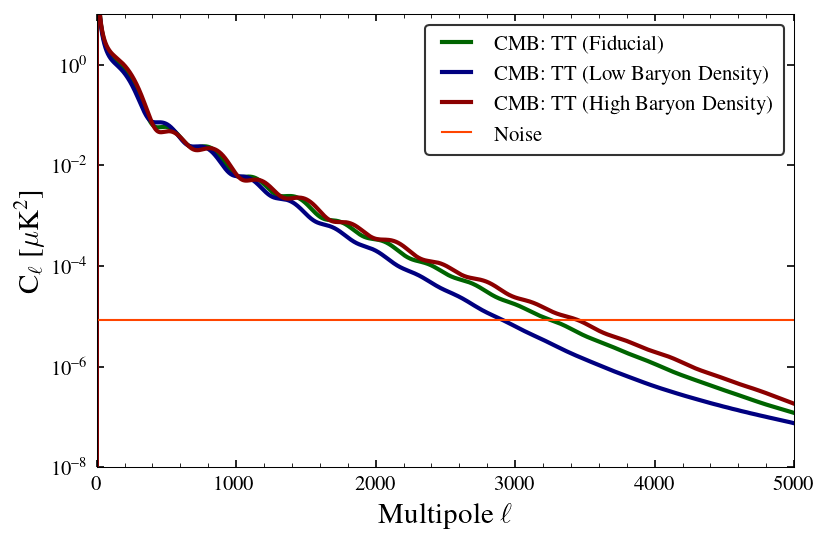

In [7]:
#show the power spectra now
use_dls = False #True
if use_dls:
    dl_fac = els * (els+1)/2/np.pi
else:
    dl_fac = 1.
ax = subplot(111, yscale = 'log')
for keyname in diff_cosmo_dic:
    labval, colorval = diff_cosmo_dic[keyname]
    curr_cl_cmb = np.copy(cl_cmb_dic[keyname])
    plot(els, dl_fac * curr_cl_cmb, color = colorval, label = r'CMB: TT (%s)' %(labval), lw = 2.)
    ###break
plot(els, dl_fac * nl, color = 'orangered', label = r'Noise')

xlabel(r'Multipole $\ell$', fontsize = 14)

if use_dls:
    ylabel(r'D$_{\ell}$ = $\ell (\ell+1)/2\pi$\ C$_{\ell}$ [$\mu$K$^{2}$]', fontsize = 14)
    ymin, ymax = 0.1, 2e4
else:
    ylabel(r'C$_{\ell}$ [$\mu$K$^{2}$]', fontsize = 14)
    ymin, ymax = 1e-8, 10.
    
xlim(0., lmax); ylim(ymin, ymax)
legend(loc = 1, fontsize = 10)
show()

In [8]:
hpf_cmb_cl = np.copy( cl_cmb )
hpf_cmb_cl[els<300.] = 0.

/Users/sraghunathan/Research/SPTpol/analysis/git/DRAFT/modules/foregrounds.py:374: RuntimeWarning: invalid value encountered in true_divide
  cl_rg = dl_rg / dl_fac
/Users/sraghunathan/Research/SPTpol/analysis/git/DRAFT/modules/foregrounds.py:233: RuntimeWarning: invalid value encountered in true_divide
  cl_dg_po = dl_dg_po / dl_fac
/Users/sraghunathan/Research/SPTpol/analysis/git/DRAFT/modules/foregrounds.py:234: RuntimeWarning: invalid value encountered in true_divide
  cl_dg_clus = dl_dg_clus / dl_fac
/var/folders/08/mkcy0rls72j2q09krs7qx2jw0000gn/T/ipykernel_63001/2684735894.py:20: RuntimeWarning: divide by zero encountered in true_divide
  cl_ksz = dl_ksz / tmp_dl_fac


{(150, 150): array([0.00000000e+00, 1.74912015e-02, 1.01540558e-02, ...,
       8.79077792e-06, 8.79025174e-06, 8.78972587e-06])}
[0.00000000e+00 9.42477796e+00 3.14159265e+00 ... 7.54736793e-07
 7.54434837e-07 7.54133063e-07] [0.00000000e+00 3.18309886e-01 9.54929659e-01 ... 3.97489566e+06
 3.97648657e+06 3.97807780e+06]


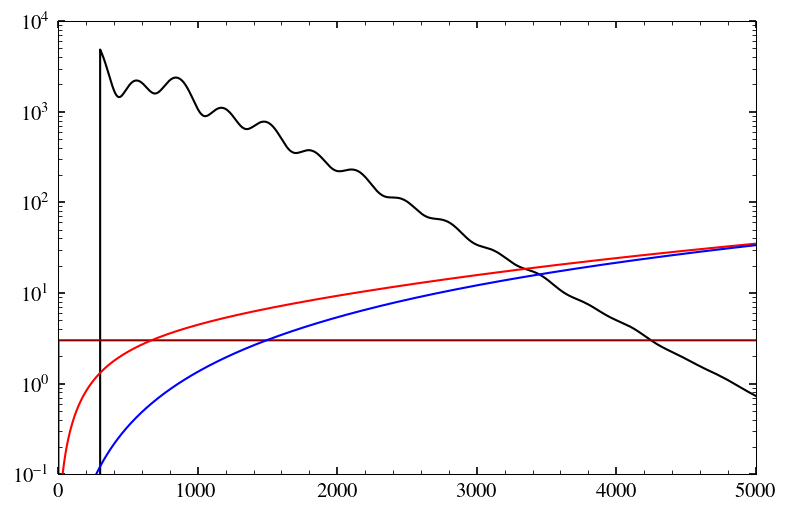

In [9]:
#foregrounds
sys.path.append('/Users/sraghunathan/Research/SPTpol/analysis/git/DRAFT/modules/')
import ilc

freqarr = [150]
param_dict = {}
param_dict['cl_tsz_freq0'] = 150
param_dict['freq0'] = 150
param_dict['fg_model'] = 'george15'
param_dict['spec_index_rg'] = -0.76
param_dict['spec_index_dg_po'] = 1.505
param_dict['spec_index_dg_clus'] = 2.51
param_dict['Tcib'] = 20.
el, cl_dic, fg_cl_dic = ilc.get_analytic_covariance(param_dict, freqarr, el = els, nl_dic = None, ignore_fg = ['cmb'], include_gal = 0, bl_dic = None)
print(cl_dic)
cl_fg = cl_dic[(150, 150)]

tmp_dl_fac = els * (els+1)/2/np.pi
dl_ksz = 3.
cl_ksz = dl_ksz / tmp_dl_fac
cl_ksz[np.isinf(cl_ksz)] = 0.
print(cl_ksz, tmp_dl_fac)

#show spectra plot
#cl_cmb = cl_cmb_dic['lcdm']
clf()
ax = subplot(111, yscale = 'log')
plot(els, tmp_dl_fac * hpf_cmb_cl)
plot(els, tmp_dl_fac * cl_ksz)
plot(els, tmp_dl_fac * cl_fg, 'red')
plot(els, tmp_dl_fac * nl, 'blue')

xlim(0., 5000.); ylim(0.1, 1e4)
show()


[0.00000000e+00 0.00000000e+00 1.01708321e+03 ... 1.21272882e-07
 1.21059062e-07 1.20847922e-07]


<Figure size 900x600 with 0 Axes>

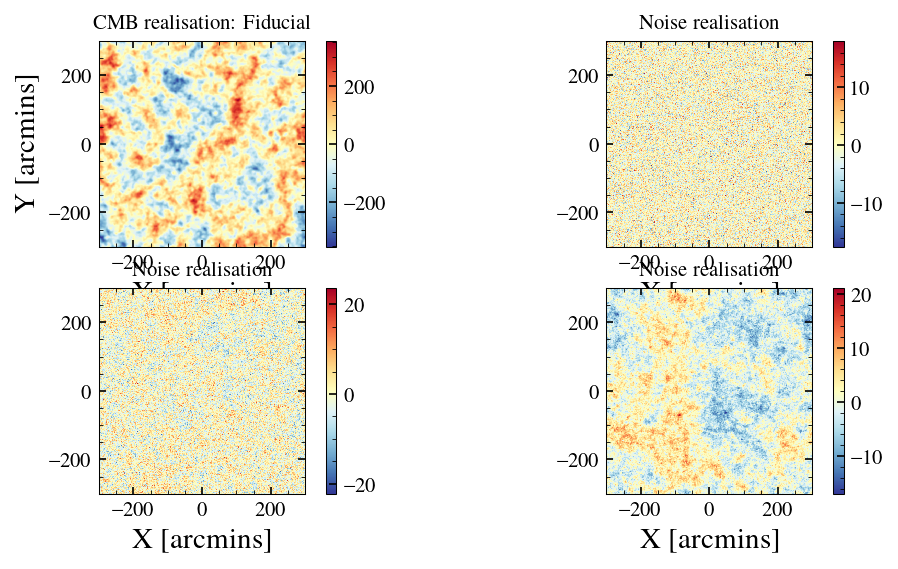

In [10]:
#create a Gaussian realisation now using the above power spectrum
np.random.seed(100)
which_cosmo = 'lcdm'
#which_cosmo = 'low_baryons'
#which_cosmo = 'more_baryons'
labval, colorval = diff_cosmo_dic[which_cosmo]
cl_cmb = cl_cmb_dic[which_cosmo]
print(cl_cmb)
mapparams = [nx, nx, dx]

mock_cmb_map = make_gaussian_realisation(mapparams, els, cl_cmb)
mock_cmb_map_hpf = make_gaussian_realisation(mapparams, els, hpf_cmb_cl)
mock_noise_map = make_gaussian_realisation(mapparams, els, nl)
mock_fg_map = make_gaussian_realisation(mapparams, els, cl_fg)
mock_ksz_map = make_gaussian_realisation(mapparams, els, cl_ksz)

clf()
figure(figsize = (8, 4))
subplot(221); imshow(mock_cmb_map, cmap = cmap, extent=[x1, x2, x1, x2]); colorbar(); title(r'CMB realisation: %s' %(labval), fontsize = 10); 
xlabel(r'X [arcmins]', fontsize = 14); ylabel(r'Y [arcmins]', fontsize = 14)
subplot(222); imshow(mock_noise_map, cmap = cmap, extent=[x1, x2, x1, x2]); colorbar(); title(r'Noise realisation', fontsize = 10); 
xlabel(r'X [arcmins]', fontsize = 14);
subplot(223); imshow(mock_fg_map, cmap = cmap, extent=[x1, x2, x1, x2]); colorbar(); title(r'Noise realisation', fontsize = 10); 
xlabel(r'X [arcmins]', fontsize = 14);
subplot(224); imshow(mock_ksz_map, cmap = cmap, extent=[x1, x2, x1, x2]); colorbar(); title(r'Noise realisation', fontsize = 10); 
xlabel(r'X [arcmins]', fontsize = 14);
show()

600 600


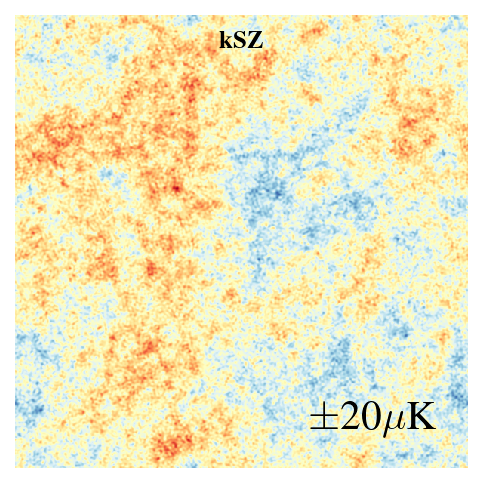

600 600


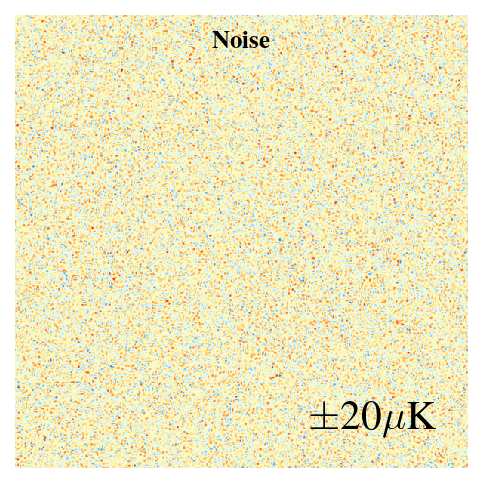

600 600


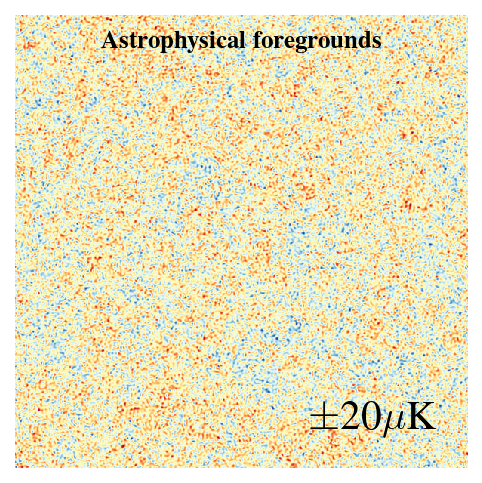

600 600


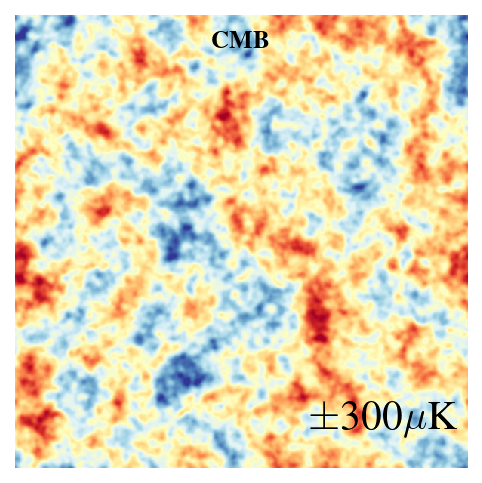

600 600


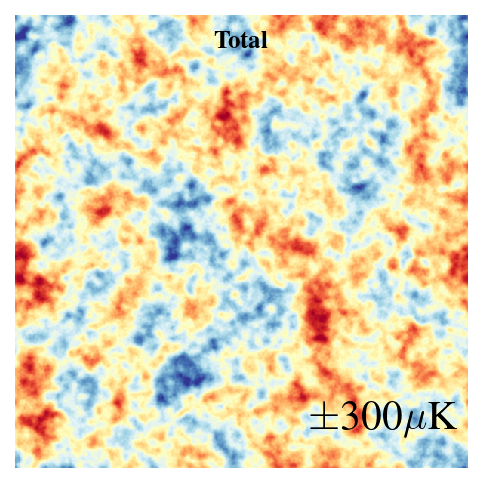

[0.00000000e+00 9.42477796e+00 3.14159265e+00 ... 7.54736793e-07
 7.54434837e-07 7.54133063e-07]


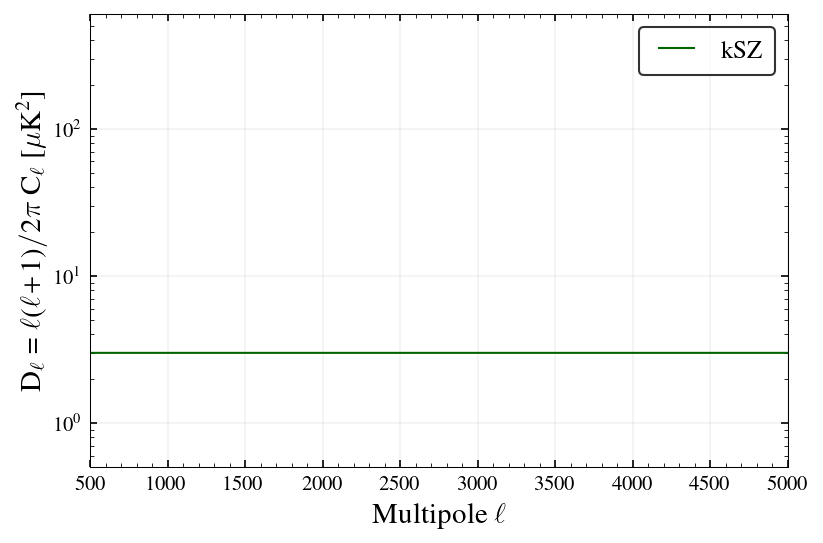

[8.46159499e-06 8.46159499e-06 8.46159499e-06 ... 8.46159499e-06
 8.46159499e-06 8.46159499e-06]


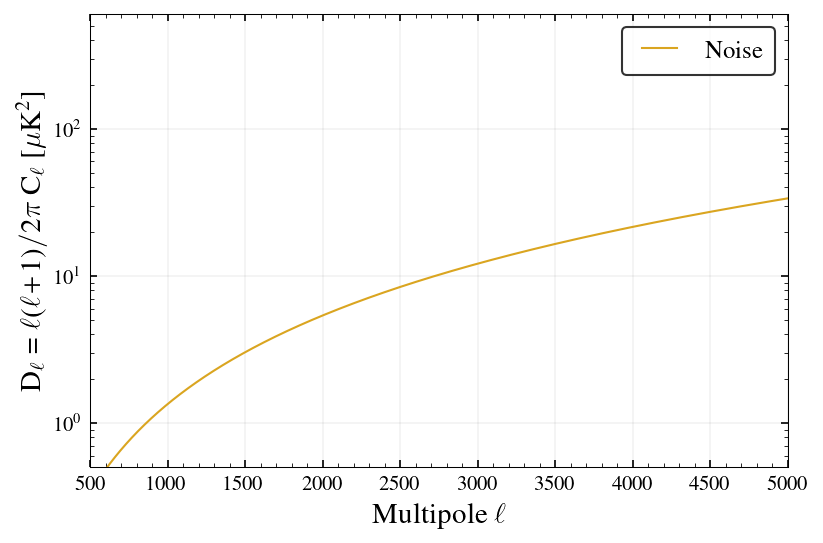

[0.00000000e+00 1.74912015e-02 1.01540558e-02 ... 8.79077792e-06
 8.79025174e-06 8.78972587e-06]


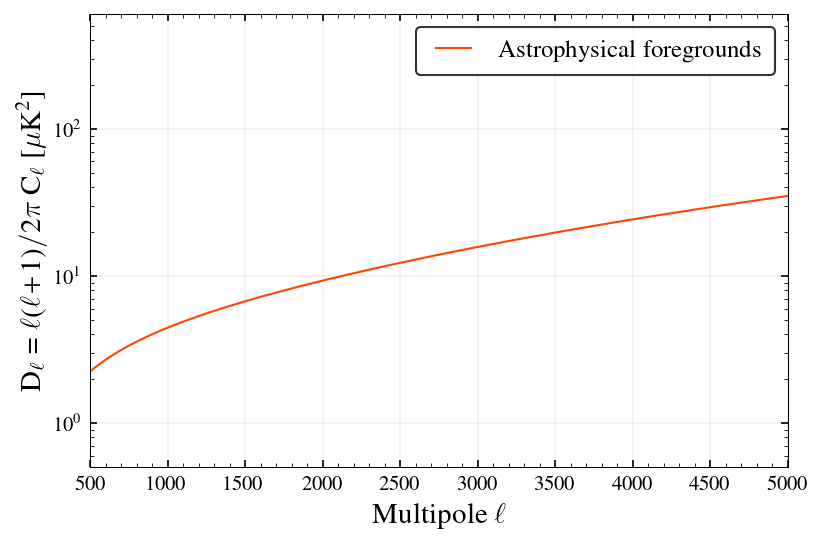

[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.84905690e-07
 1.84508082e-07 1.84114210e-07]


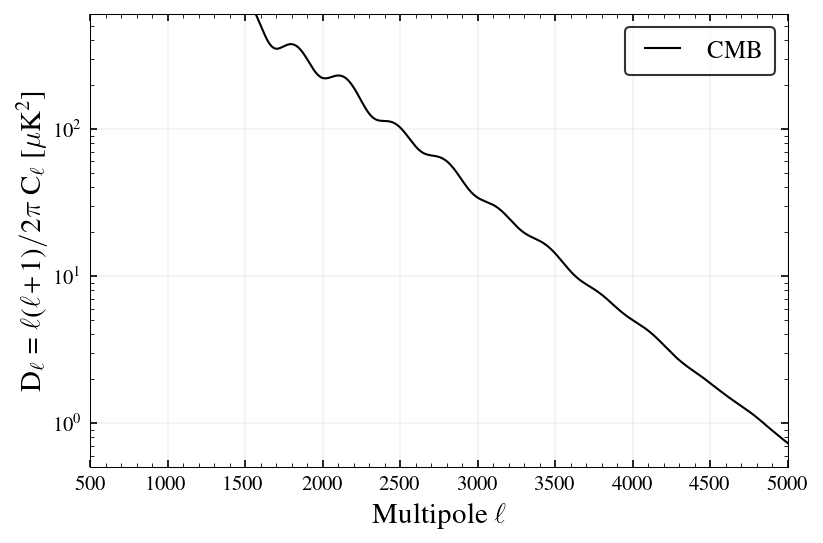

[0.00000000e+00 9.42477796e+00 3.14159265e+00 ... 7.54736793e-07
 7.54434837e-07 7.54133063e-07]
[8.46159499e-06 8.46159499e-06 8.46159499e-06 ... 8.46159499e-06
 8.46159499e-06 8.46159499e-06]
[0.00000000e+00 1.74912015e-02 1.01540558e-02 ... 8.79077792e-06
 8.79025174e-06 8.78972587e-06]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.84905690e-07
 1.84508082e-07 1.84114210e-07]


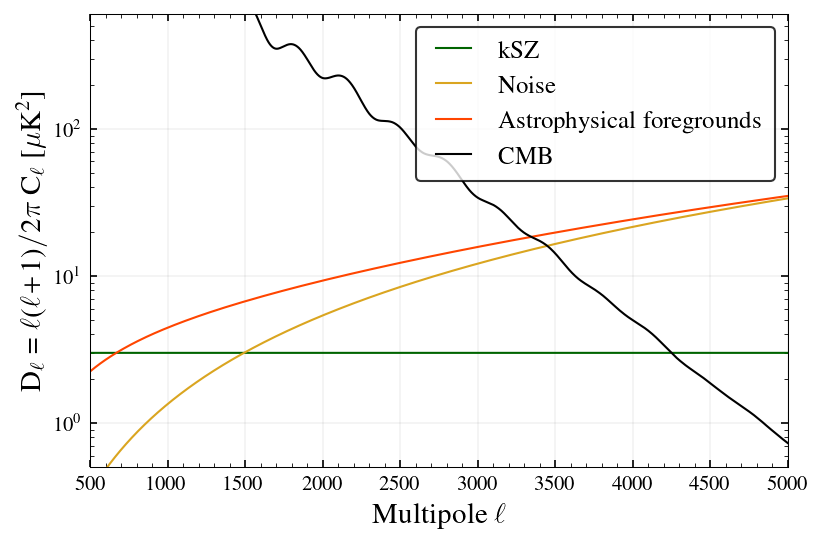

In [13]:
# Plot map and power spectra next to each other
mock_total_map = mock_cmb_map + mock_noise_map + mock_fg_map + mock_ksz_map

pl_arr = [mock_ksz_map, mock_noise_map, mock_fg_map, mock_cmb_map, mock_total_map]
tit_arr = [r'kSZ', r'Noise', r'Astrophysical foregrounds', r'CMB', r'Total']
min_max_arr = [20., 20., 20., 300., 300.]
color_arr = ['black', 'orangered', 'darkgreen']

for pliter in range(len(pl_arr)):
    ny, nx = pl_arr[pliter].shape
    print(ny, nx)
    minmax = min_max_arr[pliter]
    imshow( pl_arr[pliter], origin = 'lower', cmap = cmap, vmin = -minmax, vmax = minmax); 
    #cbar = colorbar(pad = 0.01);
    text(nx * 0.65, 50, r'$\pm %g \mu {\rm K}$' %(minmax), color = 'black', fontsize = 20)
    title(r'{\bf %s}' %tit_arr[pliter], fontsize = 12, y = 0.9)
    axis('off')
    show()

#show spectra plot
pl_arr = [cl_ksz, nl, cl_fg, hpf_cmb_cl]
tit_arr = [r'kSZ', r'Noise', r'Astrophysical foregrounds', r'CMB']
min_max_arr = [20., 20., 20., 300.]
color_arr = ['darkgreen', 'goldenrod', 'orangered', 'black']
for pliter in range(len(pl_arr)):
    print(pl_arr[pliter])
    clf()
    ax = subplot(111, yscale = 'log')
    plot(els, tmp_dl_fac * pl_arr[pliter], color = color_arr[pliter], label = r'%s' %(tit_arr[pliter]))

    xlim(500., 5000.); ylim(0.5, 6e2)
    legend(loc = 1, fontsize = 12)
    grid(True, lw = 0.2, alpha = 0.2)
    xlabel(r'Multipole $\ell$', fontsize = 14)
    ylabel(r'D$_{\ell}$ = $\ell (\ell+1)/2\pi$\ C$_{\ell}$ [$\mu$K$^{2}$]', fontsize = 14)    
    show()  
    
clf()
ax = subplot(111, yscale = 'log')
for pliter in range(len(pl_arr)):
    print(pl_arr[pliter])
    plot(els, tmp_dl_fac * pl_arr[pliter], color = color_arr[pliter], label = r'%s' %(tit_arr[pliter]))

xlabel(r'Multipole $\ell$', fontsize = 14)
ylabel(r'D$_{\ell}$ = $\ell (\ell+1)/2\pi$\ C$_{\ell}$ [$\mu$K$^{2}$]', fontsize = 14)    
xlim(500., 5000.); ylim(0.5, 6e2)
legend(loc = 1, fontsize = 12)
grid(True, lw = 0.2, alpha = 0.2)
show()      

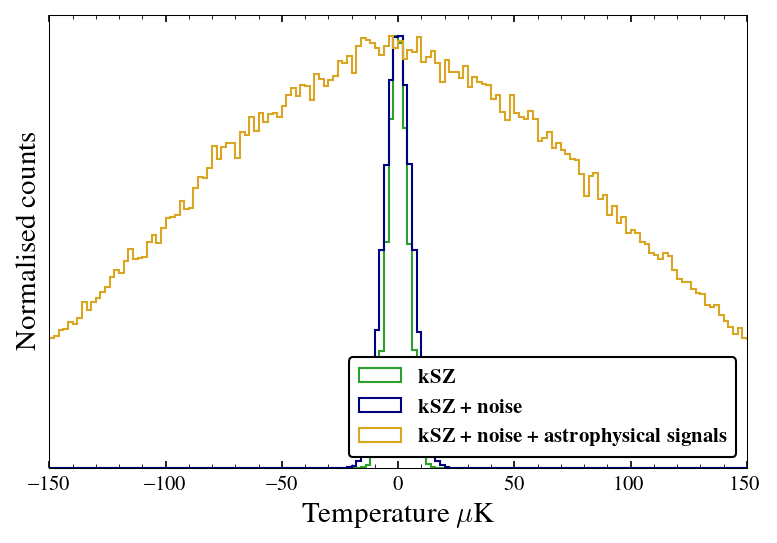

600 600


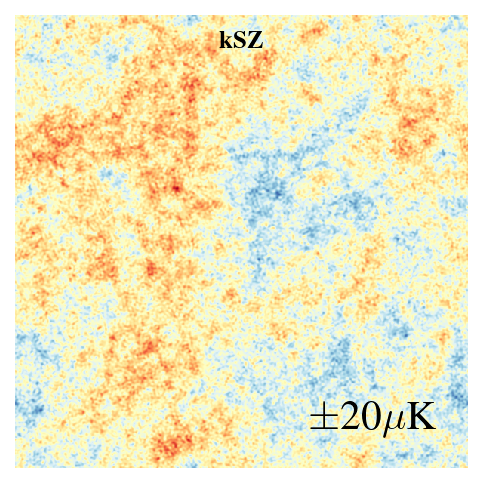

600 600


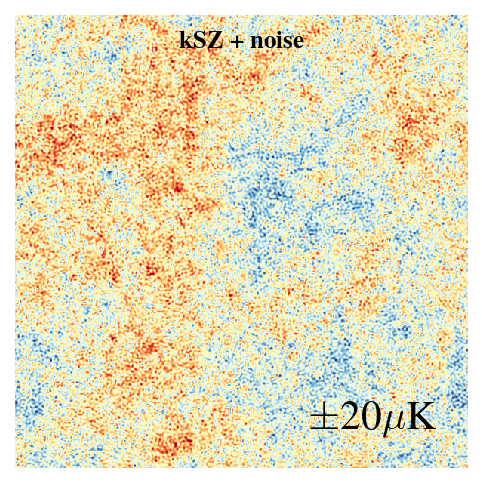

600 600


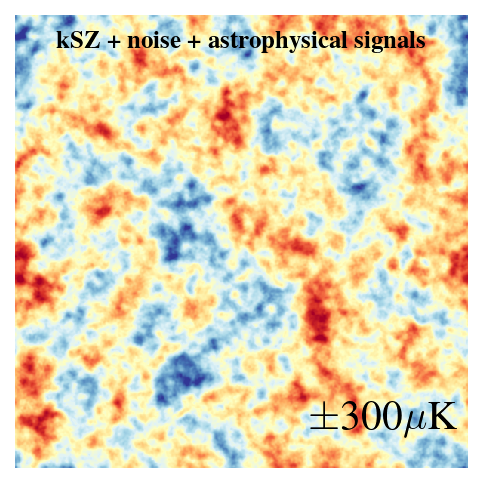

In [11]:
mock_total_map = mock_cmb_map + mock_noise_map + mock_fg_map + mock_ksz_map
mock_ksz_plus_noise_fg_map = mock_noise_map + mock_fg_map + mock_ksz_map
#imshow(mock_cmb_map, cmap = cmap); colorbar(); show()
#imshow(mock_noise_map, cmap = cmap); colorbar(); show()
#imshow(mock_fg_map, cmap = cmap); colorbar(); show()
#imshow(mock_total_map, cmap = cmap); colorbar(); show()
##imshow(mock_total_map, cmap = cmap); colorbar(); show()
##imshow(mock_ksz_map, cmap = cmap); colorbar(); show()
##imshow(mock_ksz_plus_noise_fg_map, cmap = cmap); colorbar(); show()

'''
pl_arr = [mock_ksz_map, mock_noise_map, mock_fg_map, mock_total_map]#mock_ksz_plus_noise_fg_map]
tit_arr = [r'kSZ', r'Telescope noise', r'Other astrophysical signals', r'CMB']
color_arr = ['black', 'orangered', 'darkgreen', 'navy']
'''
pl_arr = [mock_ksz_map, mock_ksz_map + mock_noise_map, mock_total_map]
tit_arr = [r'kSZ', r'kSZ + noise', r'kSZ + noise + astrophysical signals']
color_arr = ['tab:green', 'navy', 'goldenrod']


clf()
ax = subplot(111)
binbin = np.arange(-500., 500., 2.)
for pliter in range(len(pl_arr)):
    #hist( curr_map , bins = binbin, histtype = 'step', norm = 1, density = False, color = color_arr[pliter]); 
    curr_map = pl_arr[pliter].flatten()
    counts, bins = np.histogram(curr_map, bins = binbin)
    counts = counts / np.max(counts)
    hist(bins[:-1], binbin, weights=counts, histtype = 'step', color = color_arr[pliter], label = r'{\bf %s}' %tit_arr[pliter])
    #bar(bins[:-1], counts, width = 1., color = color_arr[pliter], label = tit_arr[pliter]); 
    setp(ax.get_yticklabels(which = 'both'), visible=False)
    tick_params(axis='y', which='both', length=0)
    xlim(-150., 150.)
    xlabel(r'Temperature $\mu {\rm K}$', fontsize = 14)
    ylabel(r'Normalised counts', fontsize = 14)
    legend(loc = 4, fontsize = 10, framealpha = 1.)
    plname = 'plots/%s_hist.png' %(pliter)
    savefig(plname, dpi = 200.)
show()    

pl_arr = [mock_ksz_map, mock_ksz_map + mock_noise_map, mock_total_map]#mock_ksz_plus_noise_fg_map]
tit_arr = [r'kSZ', r'kSZ + noise', r'kSZ + noise + astrophysical signals']
min_max_arr = [20., 20., 300.]
color_arr = ['black', 'orangered', 'darkgreen']

for pliter in range(len(pl_arr)):
    ny, nx = pl_arr[pliter].shape
    print(ny, nx)
    minmax = min_max_arr[pliter]
    imshow( pl_arr[pliter], origin = 'lower', cmap = cmap, vmin = -minmax, vmax = minmax); 
    #cbar = colorbar(pad = 0.01);
    text(nx * 0.65, 50, r'$\pm %g \mu {\rm K}$' %(minmax), color = 'black', fontsize = 20)
    title(r'{\bf %s}' %tit_arr[pliter], fontsize = 12, y = 0.9)
    axis('off')
    plname = 'plots/%s_map.png' %(pliter)
    ##savefig(plname, dpi = 200., bbox_inches = 'tight', pad_inches = 0)
    show()

In [50]:
savefig??

In [16]:
hist??

{(150, 150): array([0.00000000e+00, 1.74912015e-02, 1.01540558e-02, ...,
       8.79077792e-06, 8.79025174e-06, 8.78972587e-06])}


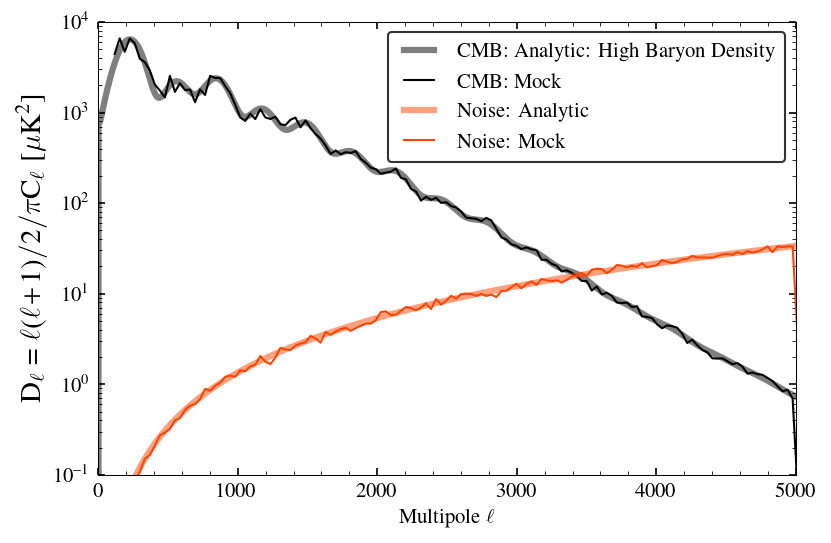

In [13]:
#make sure the above sim power spectrum matches the input
binned_els, binned_cl_cmb = map2cl(mapparams, mock_cmb_map)
binned_els, binned_nl = map2cl(mapparams, mock_noise_map)
if (1):
    dl_fac = els * (els+1)/2/np.pi
    dl_fac_binned = binned_els * (binned_els+1)/2/np.pi
    ax = subplot(111, yscale = 'log')

    plot(els, cl_cmb * dl_fac, color = 'black', label = r'CMB: Analytic: %s' %(labval), lw = 3., alpha=0.5)
    plot(binned_els, binned_cl_cmb * dl_fac_binned, color = 'black', label = r'CMB: Mock')
    
    plot(els, nl * dl_fac, color = 'orangered', label = r'Noise: Analytic', lw = 3., alpha=0.5)
    plot(binned_els, binned_nl * dl_fac_binned, color = 'orangered', label = r'Noise: Mock')

    xlabel(r'Multipole $\ell$')
    ylabel(r'D$_{\ell}$ = $\ell (\ell+1)/2/\pi$C$_{\ell}$ [$\mu$K$^{2}$]', fontsize = 14)
    ymin, ymax = 0.1, 1e4
    xlim(0, lmax); ylim(ymin, ymax)
    legend(loc = 1)
    show()  